In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

In [14]:
# Cluster center (Pleiades)
ra_center  = 56.75      # degrees
dec_center = 24.12      # degrees
radius    = 3.0         # degrees

In [15]:
query = f"""
SELECT
    ra, dec,
    parallax, parallax_error,
    pmra, pmdec,
    phot_g_mean_mag,
    phot_bp_mean_mag,
    phot_rp_mean_mag,
    ruwe
FROM gaiadr3.gaia_source
WHERE
    CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra_center}, {dec_center}, {radius})
    ) = 1
"""
job = Gaia.launch_job(query)
data = job.get_results().to_pandas()

In [16]:
data = data[
    (data["parallax"] > 0) &
    (data["parallax"] / data["parallax_error"] > 10) &
    (data["ruwe"] < 1.4)
].dropna()

In [17]:
# Distance in parsec
data["distance_pc"] = 1000.0 / data["parallax"]

# Absolute magnitude
data["M_G"] = (
    data["phot_g_mean_mag"]
    - 5 * np.log10(data["distance_pc"])
    + 5
)

# Color index
data["BP_RP"] = (
    data["phot_bp_mean_mag"]
    - data["phot_rp_mean_mag"]
)

In [18]:
plx_mean = data["parallax"].mean()
plx_std  = data["parallax"].std()

parallax_members = data[
    (data["parallax"] > plx_mean - 2 * plx_std) &
    (data["parallax"] < plx_mean + 2 * plx_std)
]

In [19]:
pmra_mean  = parallax_members["pmra"].mean()
pmdec_mean = parallax_members["pmdec"].mean()

pmra_std  = parallax_members["pmra"].std()
pmdec_std = parallax_members["pmdec"].std()

members = parallax_members[
    (np.abs(parallax_members["pmra"]  - pmra_mean)  < 2 * pmra_std) &
    (np.abs(parallax_members["pmdec"] - pmdec_mean) < 2 * pmdec_std)
]

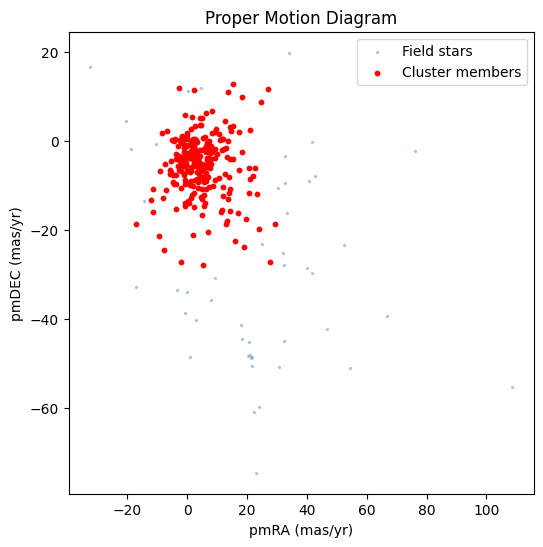

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(data["pmra"], data["pmdec"], s=2, alpha=0.3, label="Field stars")
plt.scatter(members["pmra"], members["pmdec"], s=10, color="red", label="Cluster members")
plt.xlabel("pmRA (mas/yr)")
plt.ylabel("pmDEC (mas/yr)")
plt.legend()
plt.title("Proper Motion Diagram")
plt.show()

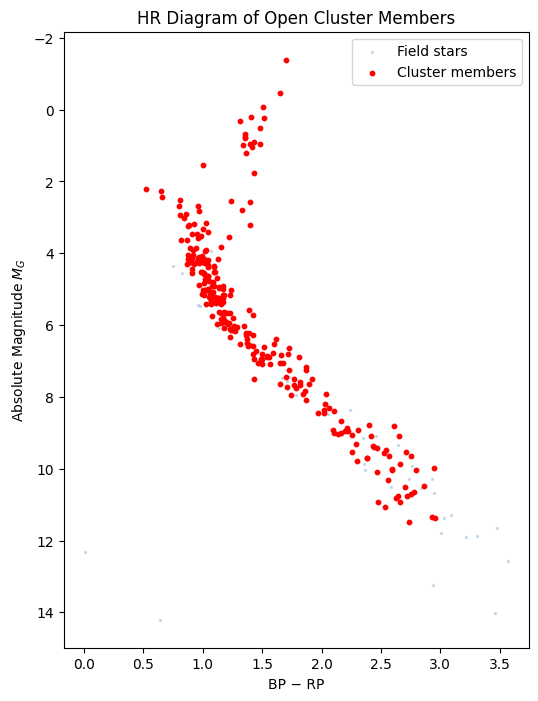

In [21]:
plt.figure(figsize=(6,8))
plt.scatter(data["BP_RP"], data["M_G"], s=2, alpha=0.2, label="Field stars")
plt.scatter(members["BP_RP"], members["M_G"], s=10, color="red", label="Cluster members")

plt.gca().invert_yaxis()
plt.xlabel("BP − RP")
plt.ylabel("Absolute Magnitude $M_G$")
plt.legend()
plt.title("HR Diagram of Open Cluster Members")
plt.show()

In [22]:
cluster_distance = members["distance_pc"].mean()
print(f"Estimated cluster distance: {cluster_distance:.1f} pc")

Estimated cluster distance: 1138.3 pc


In [23]:
members.to_csv("open_cluster_members.csv", index=False)